## Extra credit assignment

In this homework, you will use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [2]:
## read the data

data = pd.read_csv('Data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv', parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50100205,FOUR FOUR SOUTH VILLAGE TAIPEI BEEF NOODLES,Queens,3806,PRINCE ST,11354.0,7183137588,Chinese,2019-11-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.760066,-73.832570,407.0,20.0,87100.0,4439964.0,4.049720e+09,QN22
1,41434246,SILVER KITCHEN,Queens,4301,21 STREET,11101.0,7184331327,American,2018-08-15,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.750557,-73.945718,402.0,26.0,1900.0,4005198.0,4.004410e+09,QN31
2,41139783,JK & SONS COFFEE SHOP,Brooklyn,801,BROADWAY,11206.0,7187822366,American,2018-09-25,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.699713,-73.940137,304.0,34.0,38900.0,3071691.0,3.031320e+09,BK78
3,40394762,CAROLINE'S ON BROADWAY,Manhattan,750,7 AVENUE,10019.0,2127574100,American,2017-10-18,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Initial Inspection,40.760746,-73.983525,105.0,4.0,12500.0,1024795.0,1.010210e+09,MN17
4,50102980,THE HOLY GROUP,Queens,10402,NORTHERN BLVD,11368.0,9176226465,Other,2021-09-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.757684,-73.864471,403.0,21.0,37900.0,4042649.0,4.017190e+09,QN26


You only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [3]:
## keep only the above columns
columns = ['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']
data = data[columns]

### Keep data only for 2019

In [4]:
data = data[data['INSPECTION DATE'].dt.year==2019]
data.shape

(145583, 9)

### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [5]:
action1 = 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'
action2 = 'Establishment re-closed by DOHMH'
filterHandler = (data['ACTION']!=action1) & (data['ACTION']!=action2)
data = data[filterHandler]
data.shape

(139693, 9)

In [6]:
data.head(2)

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
0,50100205,11354.0,2019-11-14,Violations were cited in the following area(s).,Pesticide use not in accordance with label or ...,2.0,NaN,40.760066,-73.832570
10,50062800,10029.0,2019-09-17,Violations were cited in the following area(s).,Food Protection Certificate not held by superv...,29.0,NaN,40.786669,-73.950325


### You only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [9]:
violCat = pd.read_csv('Data/RestViol_types.csv')
violCat.head(2)

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816


In [10]:
# keep rows just for above categories
data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [11]:
data.GRADE.unique()

array(['A', nan, 'B', 'C', 'Z', 'N', 'P'], dtype=object)

In [12]:
data.shape

(62738, 9)

In [13]:
columns = (data['GRADE']!='P') & (data['GRADE']!='N') & (data['GRADE']!='Z')
data = data[columns]
data.shape

(61987, 9)

Zip codes shapefile

In [16]:
zips = gpd.read_file("Data/ZIP_CODE/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips = zips.drop_duplicates(subset='ZIPCODE')
zips.head(2)

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."


In [17]:
# # or use this
# urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
#                             "ZIPS.zip")
# with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
#     zip_ref.extractall('ZIPS/')
    
# zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
# zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
# zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
# zips.head(2)

### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [18]:
data = data[data['ZIPCODE'].notna()]
data = data.merge(zips, on='ZIPCODE', how='right')
data.shape

(61212, 11)

### Next, you need to aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [19]:
# get number of violations and average score
g1 = data[['ZIPCODE', 'CAMIS', 'SCORE']].groupby(by='ZIPCODE').agg({'SCORE': 'mean', 'CAMIS': 'count'})
g1.rename(columns={'CAMIS':'N_Violations'}, inplace=True)
g1.rename(columns={'SCORE':'Avg_SCORE'}, inplace=True)
g1.head()

,Avg_SCORE,N_Violations
ZIPCODE,,
83.0,NaN,0
10001.0,19.870285,1087
10002.0,21.900662,1512
10003.0,19.778047,1650
10004.0,22.167702,323


In [20]:
## get each grade ratio per zip code
t1 = data[['ZIPCODE', 'GRADE','CAMIS']].groupby(['ZIPCODE', 'GRADE']).count()
t2 = data[['ZIPCODE', 'GRADE']].groupby('ZIPCODE').count()
t1['CAMIS'] = t1['CAMIS'] / t2['GRADE']
g2 = t1.rename(columns={'CAMIS':'ratio'})
g2 = g2.unstack()
g2 = g2.fillna(0)
g2.head()

ratio                    
GRADE           A         B         C
ZIPCODE                              
10001.0  0.840142  0.127886  0.031972
10002.0  0.732955  0.204545  0.062500
10003.0  0.775510  0.176471  0.048019
10004.0  0.797546  0.092025  0.110429
10005.0  0.863636  0.090909  0.045455

In [21]:
mdata = g1.merge(g2, left_index=True, right_index=True)
mdata = mdata.rename(columns={
    mdata.columns[-1] : 'C',
    mdata.columns[-2] : 'B',
    mdata.columns[-3] : 'A'
})
mdata.head()

,Avg_SCORE,N_Violations,A,B,C
ZIPCODE,,,,,
10001.0,19.870285,1087,0.840142,0.127886,0.031972
10002.0,21.900662,1512,0.732955,0.204545,0.062500
10003.0,19.778047,1650,0.775510,0.176471,0.048019
10004.0,22.167702,323,0.797546,0.092025,0.110429
10005.0,18.535088,114,0.863636,0.090909,0.045455


In [22]:
mdata.shape

(206, 5)

### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [24]:
data311 = pd.read_csv('Data/311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


### Group these 311 complaints by zip code

In [25]:
data311 = data311[data311['Incident Zip'].notna()]
data311['Incident Zip'] = data311['Incident Zip'].astype('int')
data311 = data311[['Incident Zip', 'Unique Key']].groupby('Incident Zip', as_index=False).count()
data311.rename(columns={'Unique Key':'N_Complaints'}, inplace=True)
data311.head()

,Incident Zip,N_Complaints
0,0,1
1,83,1
2,10000,2
3,10001,331
4,10002,348


In [26]:
## merge with zips shapefile and normalize 311 complaints by population (per 1000 people)
data311=data311[data311['Incident Zip'].isin(zips['ZIPCODE'])]
data311=data311.merge(zips, left_on='Incident Zip', right_on='ZIPCODE')
data311=data311.drop(['Incident Zip'],axis=1)
data311.head()

,N_Complaints,ZIPCODE,POPULATION,geometry
0,1,83,25.0,"POLYGON ((998309.725 229616.681, 998282.853 22..."
1,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
2,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
3,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
4,75,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19..."


In [27]:
data311.shape

(211, 4)

In [28]:
## merge with the violations features data from above
mdata = mdata.reset_index()
data311 = data311.merge(mdata)
data311.head(2)

,N_Complaints,ZIPCODE,POPULATION,geometry,Avg_SCORE,N_Violations,A,B,C
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,1087,0.840142,0.127886,0.031972
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,1512,0.732955,0.204545,0.062500


In [29]:
data311.shape

(201, 9)

### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [30]:
data311['N_Violations'] = 1000 * data311['N_Violations'] / data311['POPULATION']
data311['N_Complaints'] = 1000 * data311['N_Complaints'] / data311['POPULATION']
data311.head()

,N_Complaints,ZIPCODE,POPULATION,geometry,Avg_SCORE,N_Violations,A,B,C
0,14.768215,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,48.498639,0.840142,0.127886,0.031972
1,4.280180,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,18.596642,0.732955,0.204545,0.062500
2,9.037546,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",19.778047,29.528616,0.775510,0.176471,0.048019
3,34.293553,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",22.167702,147.690901,0.797546,0.092025,0.110429
4,6.784261,10005,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",18.535088,14.061922,0.863636,0.090909,0.045455


In [31]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
data311 = data311[data311['N_Complaints']<30]
data311.shape

(180, 9)

### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

In [32]:
dataGeo =  gpd.GeoDataFrame(data311, geometry="geometry")
dataGeo.head(2)

,N_Complaints,ZIPCODE,POPULATION,geometry,Avg_SCORE,N_Violations,A,B,C
0,14.768215,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,48.498639,0.840142,0.127886,0.031972
1,4.280180,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,18.596642,0.732955,0.204545,0.062500


<AxesSubplot:>

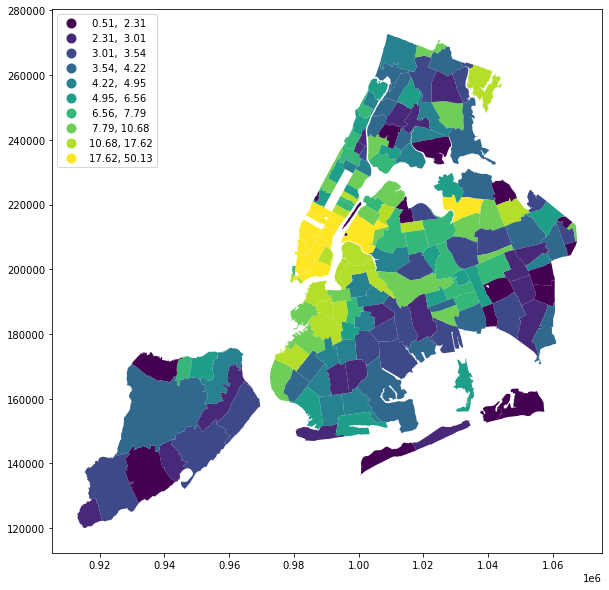

In [33]:
## normalized number of violations (per 1000 people)
fig, ax = plt.subplots(1, figsize=(10,10))
dataGeo.plot(ax=ax, column='N_Violations', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

<AxesSubplot:>

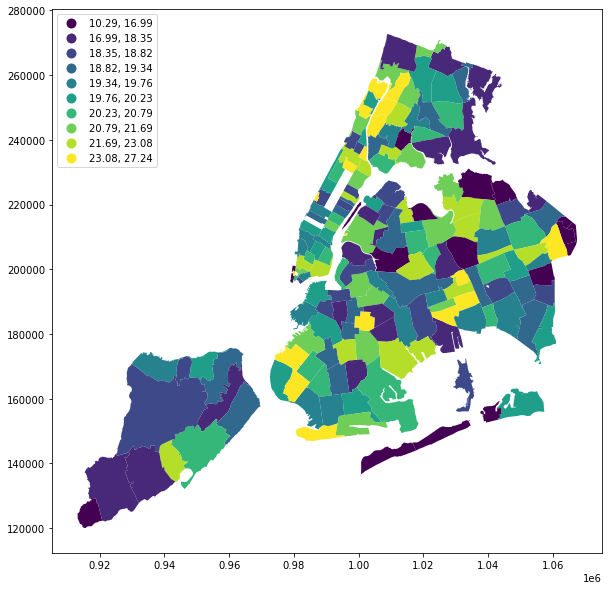

In [34]:
## average score
fig, ax = plt.subplots(1, figsize=(10,10))
dataGeo.plot(ax=ax, column='Avg_SCORE', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

<AxesSubplot:>

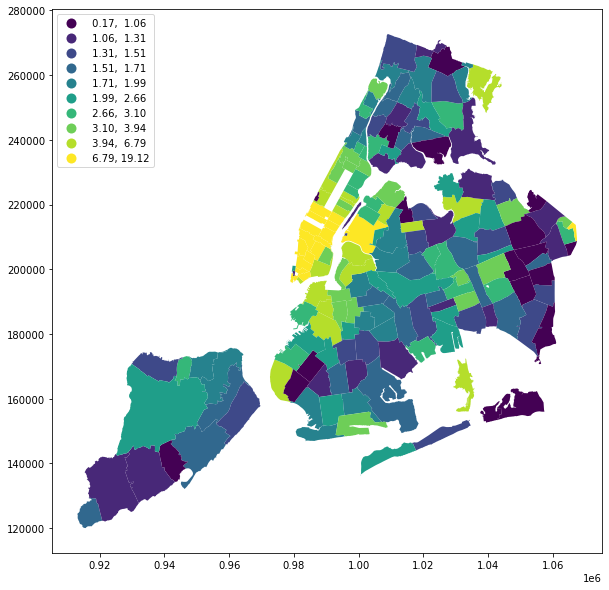

In [35]:
## normalized 311 complaints (per 1000 people)
fig, ax = plt.subplots(1, figsize=(10,10))
dataGeo.plot(ax=ax, column='N_Complaints', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [36]:
columns = ['N_Violations','Avg_SCORE', 'A', 'B', 'C']
cdata = dataGeo[columns]

In [37]:
## perform clustring analyses
## use average silhouette score (just report the scores and choose best for number of clusters to be used)
## try with (3-15 clusters)
for n_clusters in range(3,16):
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(cdata)
    silhouette_avg = silhouette_score(cdata, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =3, the average silhouette_score is :0.5483780214659482
For n_clusters =4, the average silhouette_score is :0.5486890756964184
For n_clusters =5, the average silhouette_score is :0.3870439632440377
For n_clusters =6, the average silhouette_score is :0.37517595877686744
For n_clusters =7, the average silhouette_score is :0.41096080855696315
For n_clusters =8, the average silhouette_score is :0.4043882160594889
For n_clusters =9, the average silhouette_score is :0.40447094518991883
For n_clusters =10, the average silhouette_score is :0.3810100186967406
For n_clusters =11, the average silhouette_score is :0.38439090923457936
For n_clusters =12, the average silhouette_score is :0.39204222637617847
For n_clusters =13, the average silhouette_score is :0.38359440012339485
For n_clusters =14, the average silhouette_score is :0.3849289389325686
For n_clusters =15, the average silhouette_score is :0.3863983197083954


<AxesSubplot:>

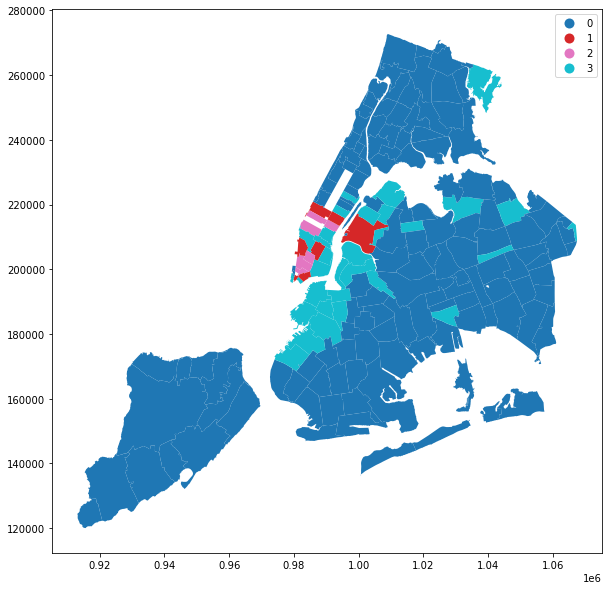

In [38]:
## plot all clustered zips in the map
model = KMeans(n_clusters=4, random_state=324).fit(dataGeo[columns])
dataGeo['label'] = model.predict(dataGeo[columns]).astype(str)
f, ax = plt.subplots(1, figsize=(10,10))
dataGeo.plot(axes=ax, column='label', legend = True)

### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

In [39]:
dataGeo = dataGeo[dataGeo['ZIPCODE']!=10069]

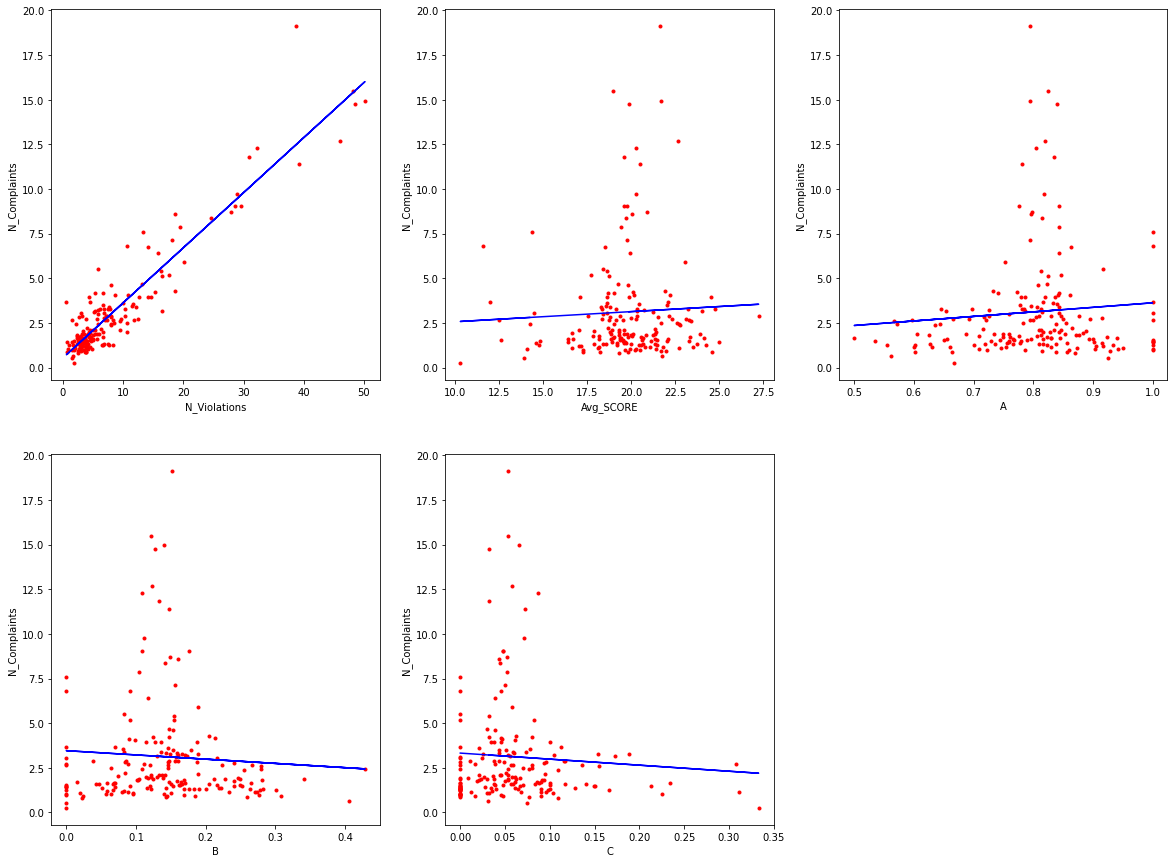

In [40]:
plt.figure(figsize = (20,15))
pList = {}
for i, f in enumerate(columns):
    plt.subplot(230+i+1)
    lm = smf.ols(formula = 'N_Complaints ~ ' + f, data = dataGeo).fit()
    plt.plot(dataGeo[f],dataGeo['N_Complaints'],'.r')
    plt.plot(dataGeo[f],lm.predict(),'b')
    plt.xlabel(f)
    plt.ylabel('N_Complaints')
    pList[f] = lm.pvalues[f]

In [41]:
pList

{'N_Violations': 4.739182552213573e-82,
 'Avg_SCORE': 0.5153858216999618,
 'A': 0.25204720166598676,
 'B': 0.3977200623780347,
 'C': 0.39404036207376747}

<span style='color:red;font-size:18pt'> If doing regression with all regressors together,  only N_violations are significant</span>

In [42]:
lm = smf.ols(formula = 'N_Complaints ~ ' +'+'.join(columns), data = dataGeo).fit()
lm.pvalues

Intercept       6.277363e-01
N_Violations    1.067752e-81
Avg_SCORE       3.981743e-01
A               1.524220e-02
B               2.719164e-01
C               8.513648e-01
dtype: float64

<span style='color:red;font-size:18pt'> If doing regression with all regressors together, A and N_violations are significant</span>

<span style='color:red;font-size:18pt'>Compare with the single feature regression, multiple regressor consider more about the relation between features. At the same time, every features coefficient are effectted by the others. As we can see in the multiple feature regression. Except C, all the features' pvalue are become closer </span>